In [1]:
#wandb is to visualise the processing remotely! to have the access to a local machine, or in cloud and visualise it
%pip install wandb -qqq

Note: you may need to restart the kernel to use updated packages.


In [2]:

import wandb
wandb.login(key='')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ib_nouri. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/Saif/.netrc


True

In [4]:
#this is another way to login which I personally use
!wandb login

wandb: Currently logged in as: ib_nouri. Use `wandb login --relogin` to force relogin


In [3]:
%pip install torch  torchvision matplotlib numpy tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importing lib
import torch, pdb, os, torchvision, PIL
from torch import nn
import matplotlib.pyplot as plt
from  torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image



def show(tensor,number=25, wandbactive=0, name=''):
  data= tensor.detach().cpu()
  grid= make_grid(data[:number]).permute(1,2,0)
  if (wandbactive==1):
   wandb.log({name: wandb.Image(grid.numpy().clip(0,1))})

  plt.imshow(grid.clip(0,1))
  plt.show()

/Users/Saif/Desktop/AI/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#general parameters and hyperparameters
n_epochs=100
batch_size=128
cur_step=0
z_dim=200
lr=1e-4
device='cpu'
critic_cycle=5
#the number of cycles we will define for the discriminator, so 5 cycles of disctiminator vs 1 cycle of generator
gen_losses= []
critic_losses=[]
show_steps=35
save_steps=35
wandbact=1

In [6]:
%%capture
experiment_name=wandb.util.generate_id()
myrun= wandb.init(
    project="Adv WGAN",
    group=experiment_name,
    config={
        "n_epoch":"1000",
        "batch_size":128,
        "optimzer":"Adam"
    }
)
config=wandb.config

In [7]:
print(experiment_name)

qlkk4vxs


In [8]:
#Generator class

class Generator(nn.Module):
  def __init__(self, z_dim=64, d_dim=16):
    super(Generator, self).__init__()
    self.z_dim=z_dim

    self.gen = nn.Sequential(
            ## ConvTranspose2d: in_channels, out_channels, kernel_size, stride=1, padding=0
            ## Calculating new width and height: (n-1)*stride -2*padding +ks
            ## n = width or height
            ## ks = kernel size
            ## we begin with a 1x1 image with z_dim number of channels (200)
            nn.ConvTranspose2d(z_dim, d_dim * 32, 4, 1, 0), ## 4x4 (ch: 200, 512)
            nn.BatchNorm2d(d_dim*32),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1), ## 8x8 (ch: 512, 256)
            nn.BatchNorm2d(d_dim*16),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1), ## 16x16 (ch: 256, 128)
            #(n-1)*stride -2*padding +ks = (8-1)*2-2*1+4=16
            nn.BatchNorm2d(d_dim*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(d_dim*8, d_dim*4, 4, 2, 1), ## 32x32 (ch: 128, 64)
            nn.BatchNorm2d(d_dim*4),
            nn.ReLU(True),            

            nn.ConvTranspose2d(d_dim*4, d_dim*2, 4, 2, 1), ## 64x64 (ch: 64, 32)
            nn.BatchNorm2d(d_dim*2),
            nn.ReLU(True),            

            nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1), ## 128x128 (ch: 32, 3)
            nn.Tanh() ### produce result in the range from -1 to 1
    )


  def forward(self, noise):
    x=noise.view(len(noise), self.z_dim, 1, 1)  # 128 x 200 x 1 x 1
    return self.gen(x)


def gen_noise(num, z_dim, device='cpu'):
   return torch.randn(num, z_dim, device=device) # 128 x 200



In [9]:
#Critic Class
class Critic(nn.Module):
  def __init__(self, d_dim=16):
    super(Critic, self).__init__()

    self.crit = nn.Sequential(
      # Conv2d: in_channels, out_channels, kernel_size, stride=1, padding=0
      ## New width and height: # (n+2*pad-ks)//stride +1
      nn.Conv2d(3, d_dim, 4, 2, 1), #(n+2*pad-ks)//stride +1 = (128+2*1-4)//2+1=64x64 (ch: 3,16)
      nn.InstanceNorm2d(d_dim), 
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim, d_dim*2, 4, 2, 1), ## 32x32 (ch: 16, 32)
      nn.InstanceNorm2d(d_dim*2), 
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1), ## 16x16 (ch: 32, 64)
      nn.InstanceNorm2d(d_dim*4), 
      nn.LeakyReLU(0.2),
              
      nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1), ## 8x8 (ch: 64, 128)
      nn.InstanceNorm2d(d_dim*8), 
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1), ## 4x4 (ch: 128, 256)
      nn.InstanceNorm2d(d_dim*16), 
      nn.LeakyReLU(0.2),

      nn.Conv2d(d_dim*16, 1, 4, 1, 0), #(n+2*pad-ks)//stride +1=(4+2*0-4)//1+1= 1X1 (ch: 256,1)

    )


  def forward(self, image):
    # image: 128 x 3 x 128 x 128
    crit_pred = self.crit(image) # 128 x 1 x 1 x 1
    return crit_pred.view(len(crit_pred),-1) ## 128 x 1  

In [10]:
# I can here initialise my weights, it is optional phase but
def initWeights(m):
  ### I will make it later ###
   return 0

#gen= gen.apply(initWeights)
#crit= crit.apply(initWeights)

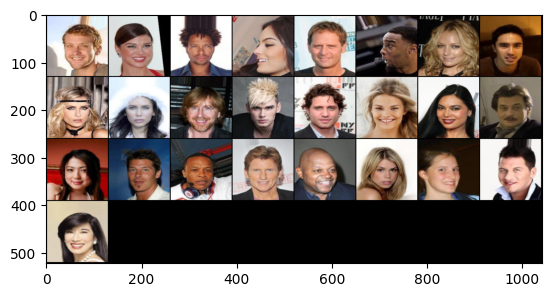

In [11]:
class Dataset(Dataset):
  def __init__(self, path, size=128, lim=10000):
    self.sizes=[size, size]
    items, labels=[],[]

    for data in os.listdir(path)[:lim]:
      item = os.path.join(path,data)
      items.append(item)
      labels.append(data)
    self.items=items
    self.labels=labels


  def __len__(self):
    return len(self.items)

  def __getitem__(self,idx):
    data = PIL.Image.open(self.items[idx]).convert('RGB') # (178,218)
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # 128 x 128 x 3
    data = np.transpose(data, (2,0,1)).astype(np.float32, copy=False) # 3 x 128 x 128 # from 0 to 255
    data = torch.from_numpy(data).div(255) # from 0 to 1
    return data, self.labels[idx]

## Dataset
data_path='./data/celeba/img_align_celeba'
ds = Dataset(data_path, size=128, lim=10000)

## DataLoader
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

## Models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

## Optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5,0.9))
crit_opt= torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5,0.9))

## Initializations
##gen=gen.apply(init_weights)
##crit=crit.apply(init_weights)

#wandb optional
if (wandbact==1):
  wandb.watch(gen, log_freq=100)
  wandb.watch(crit, log_freq=100)

x,y=next(iter(dataloader))
show(x)

In [12]:
# Gradient penalty calculation
def get_gp(real, fake, crit, alpha, gamma=10):
  mix_images = real * alpha + fake * (1-alpha) # 128 x 3 x 128 x 128
  mix_scores = crit(mix_images) # 128 x 1

  gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs=torch.ones_like(mix_scores),
      retain_graph=True,
      create_graph=True,
  )[0] # 128 x 3 x 128 x 128

  gradient = gradient.view(len(gradient), -1)   # 128 x 49152
  gradient_norm = gradient.norm(2, dim=1) 
  gp = gamma * ((gradient_norm-1)**2).mean()

  return gp


In [14]:
#Save and Load Checkpoints
root_path='data/celeba'
def savecheckpoints(name):
   # Save the generator model
      #epochs
      #model
      #optimizer, and then the destination
  torch.save({
     'epoch':epoch,
      'model_state_dict':gen.state_dict(),
      'optimizer_state_dict':gen_opt.state_dict(),
  }, f"{root_path}G-{name}.pkl")
   # Save the Critic model
  torch.save({
      'epoch':epoch,
      'model_state_dict': crit.state_dict(),
      'optimizer_state_dict': crit_opt.state_dict()
  }, f"{root_path}C-{name}.pkl")
  print("Checkpoints saved successuflly")


def Loadcheckpoint(name):
  #Generator
  checkp=torch.load(f'{root_path}-G{name}.pkl')
  gen.load_state_dict(checkp['model_state_dict'])
  gen_opt.load_state_dict(checkp['optimizer_state_dict'])
  #Critic
  checkpoint = torch.load(f"{root_path}C-{name}.pkl")
  crit.load_state_dict(checkpoint['model_state_dict'])
  crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  print('Checkpoints loaded successfully')


  0%|          | 0/79 [00:00<?, ?it/s]

Saving checkpoint:  0 35
Checkpoints saved successuflly


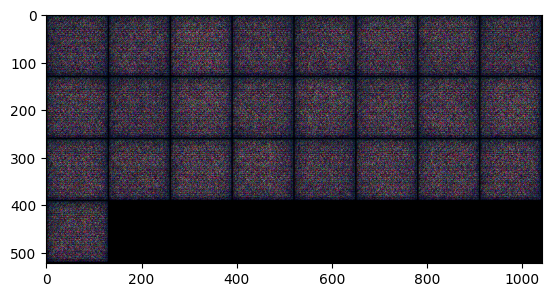

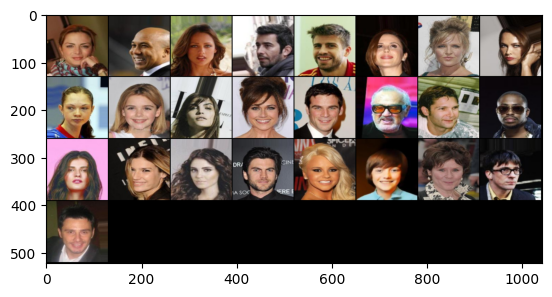

Epoch: 0: Step 0: Generator loss: -0.018939670281750816, critic loss: 3.1423979296003073


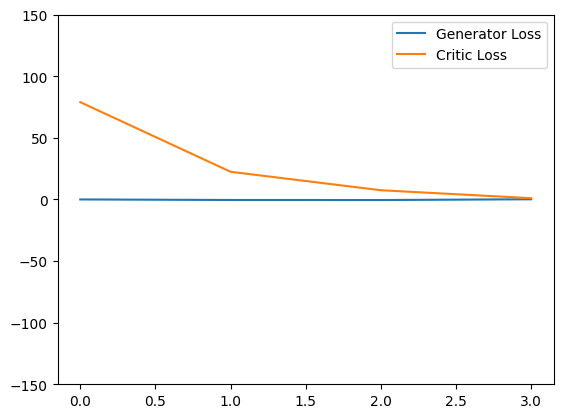

  1%|▏         | 1/79 [00:17<22:46, 17.52s/it]

Saving checkpoint:  0 35
Checkpoints saved successuflly


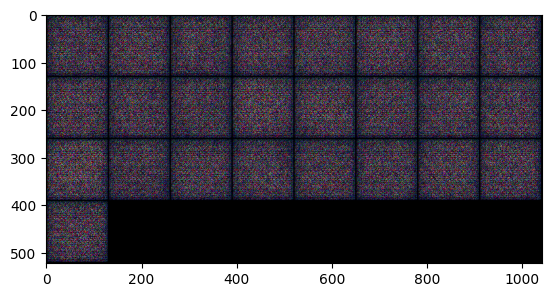

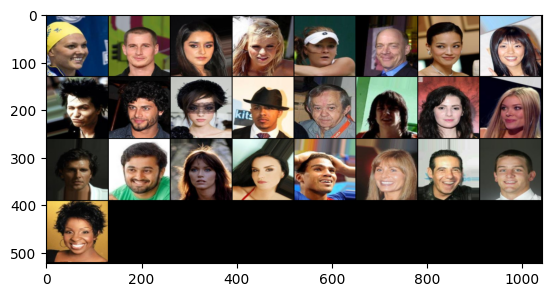

Epoch: 0: Step 0: Generator loss: 0.0027558788657188415, critic loss: 3.1378715654781892


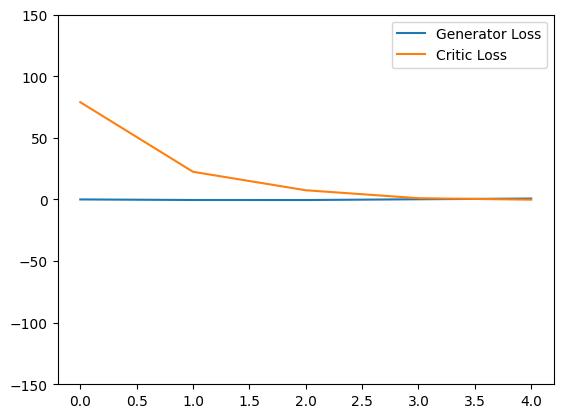

  3%|▎         | 2/79 [00:34<22:12, 17.31s/it]

Saving checkpoint:  0 35
Checkpoints saved successuflly


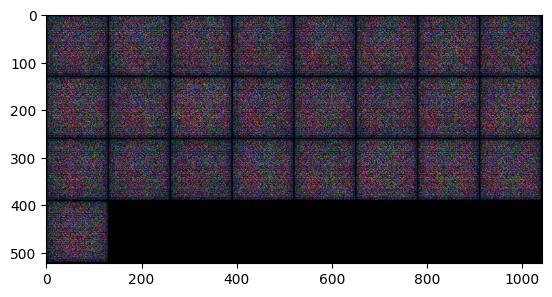

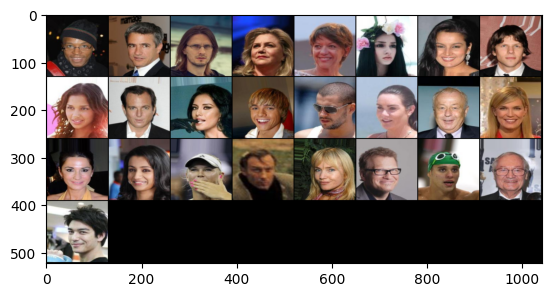

Epoch: 0: Step 0: Generator loss: 0.047344291423048294, critic loss: 3.1068861011096414


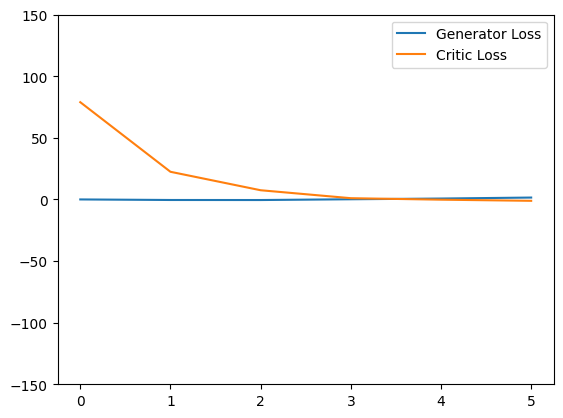

  4%|▍         | 3/79 [00:53<23:02, 18.20s/it]

Saving checkpoint:  0 35
Checkpoints saved successuflly


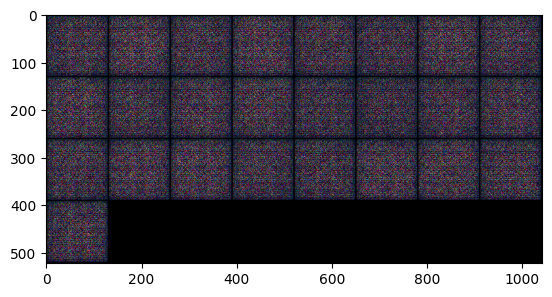

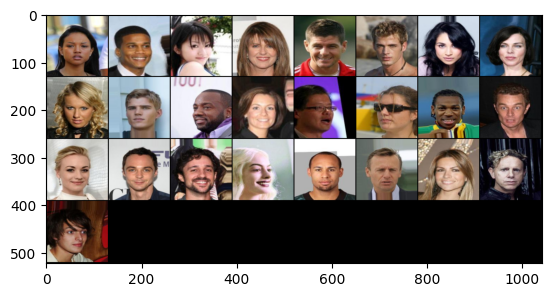

Epoch: 0: Step 0: Generator loss: 0.11261981065784182, critic loss: 3.0482100742203855


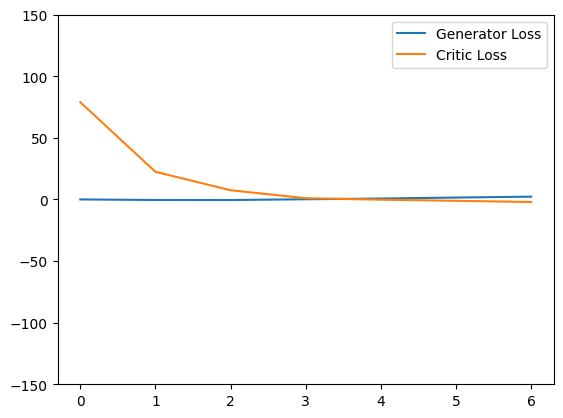

  5%|▌         | 4/79 [01:28<27:41, 22.16s/it]


KeyboardInterrupt: 

In [16]:
#Training Loop
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_bs=len(real)
        real=real.to(device)
        #Critic LOOP
        crit_loss_mean=0
        for _ in range(critic_cycle):
            crit_opt.zero_grad()
            noise=gen_noise(cur_bs, z_dim)
            fake=gen(noise)
            crit_fake_pred=crit(fake.detach())
            crit_real_pred=crit(real)
            alpha=torch.rand(len(real),1,1,1, device=device, requires_grad=True)
            gp=get_gp(real, fake.detach(), crit, alpha)
            crit_loss=crit_fake_pred.mean()- crit_real_pred.mean() +gp
            crit_loss_mean+=crit_loss.item()/critic_cycle
            crit_loss.backward(retain_graph=True)
            crit_opt.step()

        critic_losses+=[crit_loss_mean]
        #Generator   
        gen_opt.zero_grad()
        noise=gen_noise(cur_bs, z_dim)
        fake=gen(noise)
        gen_fake_pred=crit(fake)
        gen_loss=-gen_fake_pred.mean()
        gen_loss.backward()
        gen_opt.step()

        gen_losses+=[gen_loss.item()]
        #Stats 
        if (wandbact==1):
           wandb.log({'Epoch': epoch, 'Step': cur_step, 'Critic loss':crit_loss_mean, 'Gen loss': gen_loss})

        if (cur_step % save_steps == 0 or cur_step > 0):
            print("Saving checkpoint: ", cur_step, save_steps)
            savecheckpoints("latest")

        if (cur_step % show_steps == 0 or cur_step > 0):
            show(fake, wandbactive=1, name='fake')
            show(real, wandbactive=1, name='real')

        gen_mean=sum(gen_losses[-show_steps:]) / show_steps
        crit_mean = sum(critic_losses[-show_steps:]) / show_steps
        print(f"Epoch: {epoch}: Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")

        plt.plot(
          range(len(gen_losses)),
          torch.Tensor(gen_losses),
          label="Generator Loss"
      )

        plt.plot(
          range(len(gen_losses)),
          torch.Tensor(critic_losses),
          label="Critic Loss"
      )

        plt.ylim(-150,150)
        plt.legend()
        plt.show()
    
    cur_step+=1

        
    


